Autor : Henrique Torres de Lima <br>
Ano : 2019

### Importando as bibliotecas utilizadas.

In [139]:
import numpy as np
import math 
from matplotlib import pyplot as plt

### O corpo a ser estudado é uma viga com uma extremidade engastada. 
### Descrição da viga:

In [140]:
P = -5 # Força, em KN, na extremidade direita da viga.
L = 200 # Largura da viga em cm.
h0 = 10 # Altura da viga em cm.
M = int(L/h0) # Relação largura por altura.
E = 2.07*10**4 # Modulo de elasticidade da viga em KN/cm^2
v = 0.3 # Coeficiente de Poisson
t = 2 # Espessura da viga em cm.
I = t*h0**3/12 # Inercia em cm^4.

### Elementos:

Um bloco de elemento definido como dois elementos triangulares retângulos isósceles, sendo seus catetos de dimensão h.
Seu esboço pode ser visto a seguir.

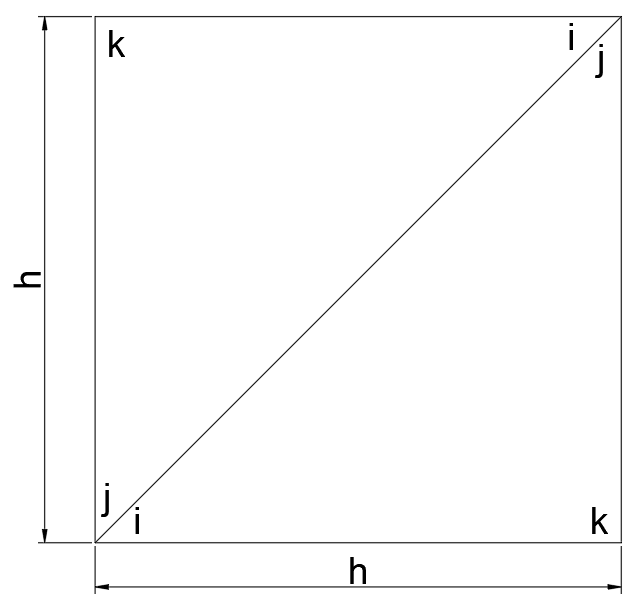

Note que, apesar de semelhantes, (1) e (2) são elementos distintos e devem ter características como sua matriz de rigidez([k]), matriz de
transformação ([Lmd]) e sua matriz [B] diferentes. Os vértices de cada elemento são rotulados por 'i','j','k'.


In [141]:
n = 5

 Relevante para a geração da malha, "n" é o número de subdivisões da altura do elemento,
      mais especificamente, "n" define a altura do elemento e impacta na quantidade de elementos.
       Quanto maior o "n" maior a precisão, porem, maior o tempo computacional.

### Exemplo:

Se n = 2 e h0 = 10cm (Altura da viga) então temos que um elemento da malha vai ter altura:
h = h0/n = 10/2 = 5 cm
Se a viga tem L = 100cm (Largura da viga) então será necessário que a malha tenha:
L/h = 100/5 = 20 blocos de elementos na horizontal. Como n = 2, então temos que a quantidade de elementos que compõe a malha é descrita por:
(L/h)*2*n = 20*(número de blocos)*2(elementos em cada bloco)*2(divisões da viga) = 80 elementos.
Vale notar que, em geral, o número de elementos de uma dada malha pode ser calculada como:
(L/h)*2*n = [L/(h0/n)]*2*n = 2*(L/h0)*n^2 = 2*M*n^2.

In [142]:
if 2*M*n**2 > 12000: #Avaliação do número de elementos.
    print("Atenção, o número de elementos na malha é muito grande. Podendo causar problemas de desempenho no computador.")
    print("Numero de elementos: ",2*M*n**2)
    Certeza = input("Insira 's' para continuar qualquer outra coisa para cancelar.")
    if Certeza == "s" or Certeza == "S":
        print("Prosseguindo.")
    else:
        exit()

'M' tem que ser um número inteiro para o programa funcionar, portanto, se M =! L/h0 então não é possível realizar uma malha corretamente.

In [143]:
if M/(L/h0) == 1: 
    print("Ok")
    print("Relação L/h0 = ", M)
    if M< 5 :
        print("A relação L/h0 escolhida esta baixa.")
else:
    '''
    Se a relação não der um número inteiro os elementos não englobam todo o corpo.
    '''
    print("Cuidado, a relação L/h0 não é um número inteiro e, consequentemente, não apresenta resultados confiáveis.") 
                                                                                                                        
print("Numero de elementos da malha:",2*M*n**2)

Ok
Relação L/h0 =  20
Numero de elementos da malha: 1000


## Descrição dos elementos:

In [144]:
h = (h0/n) # Altura e largura de cada elemento.
'''
Dimensões dos dois elementos em um bloco qualquer. Note que as variáveis a 
baixo são tupler onde sua primeira posição pertence ao elemento tipo (1) 
e a segunda posição ao elemento tipo (2).
'''
Xi = (0,h) #posição no eixo X no vértice i do elemento.
Yi = (0,h) #posição no eixo Y no vértice i do elemento.
Xj = (h,0) #posição no eixo X no vértice j do elemento.
Yj = (h,0) #posição no eixo Y no vértice j do elemento.
Xk = (h,0) #posição no eixo X no vértice k do elemento.
Yk = (0,h) #posição no eixo Y no vértice k do elemento.
A = h**2/2 # Área do elemento


### Matriz deslocamento-deformação [B]. Capitulo 10.2, pág. 381 do livro (Rao,2018); Capitulo 5.3.3,pág. 143 (Alves,2014).

In [145]:
B = []
for e in range(2):
    #Matriz [B] no elemento 'e'.
    Bs = (1/(A*2))*np.array([[Yk[e]-Yj[e],0,-(Yk[e]-Yi[e]),0,Yj[e]-Yi[e],0],
                    [0,-(Xk[e]-Xj[e]),0,Xk[e]-Xi[e],0,-(Xj[e]-Xi[e])],
                    [-(Xk[e]-Xj[e]),Yk[e]-Yj[e],Xk[e]-Xi[e],-(Yk[e]-Yi[e]),-(Xj[e]-Xi[e]),Yj[e]-Yi[e]]])
    B.append(Bs) #Lista contendo as duas matrizes [B]

### Inversa da matriz de coeficientes elástico, matriz [D]. Capitulo 10.2, pág. 381 do livro (Rao,2018).


In [146]:
D = E/(1-v**2)*np.array([[1,v,0],
                          [v,1,0],
                    [0,0,(1-v)/2]])

### Matriz de rigidez local [k]. Capitulo 10.2, pág. 381 do livro (Rao,2018).

[k] = integral([B].T * [D] * [B])Dv = t*A*([B].T * [D] * [B])


k = []
for e in range(2):
    k.append(t*A*np.dot(np.dot(B[e].T,D),B[e]))


In [147]:
k = []
for e in range(2):
    
    k.append(t*A*np.dot(np.dot(B[e].T,D),B[e]))

### Matriz de rigidez global.

Com a matriz global ainda é necessário fazer a ordenação dos 
nódulo para associa-los com cada [K]. Sendo que, a enumeração dos nódulo é feita da esquerda para direita, de baixo para cima.

Exemplo: Se n = 1 e M = 1, para o elemento 1: <br>
pontas $\;\;$ i$\;$  j$\;$  k $\;$     <br>
nó$\;\;\;\;\;\;\;\;$1 4 3

In [148]:
Ordem = []
Ordem_K = []
elem = 0
for J in range(M*n):
    a = 0
    b = 0
    for Col in range(1,2*n+1):
        elem += 1
        if elem % 2 != 0: # Os elementos impares são diferentes dos pares.
            a += 1
            Ordem.append([J*n+J+a,(J+1)*n+J+2+a,(J+1)*n+J+1+a]) #Criando lista que orienta a posição de cada nódulo em cada elemento ímpar.
            Ordem_K.append([2*Ordem[elem-1][0]-1,2*Ordem[elem-1][0],2*Ordem[elem-1][1]-1,2*Ordem[elem-1][1],2*Ordem[elem-1][2]-1,2*Ordem[elem-1][2]]) #Usando lista acima para orientar as matrizes [K] impar. 
        else:
            b += 1
            Ordem.append([(J+1)*n+J+2+b,J*n+J+b,J*n+J+1+b])#Criando lista que orienta a posição de cada nódulo em cada elemento par.
            Ordem_K.append([2*Ordem[elem-1][0]-1,2*Ordem[elem-1][0],2*Ordem[elem-1][1]-1,2*Ordem[elem-1][1],2*Ordem[elem-1][2]-1,2*Ordem[elem-1][2]]) #Usando lista acima para orientar as matrizes [K] par.


(M*n*(n+1)+n+1) é o número de nódulos. Como cada nódulo tem uma deformação na direção x e em y, [_K_] tem de ser de dimensão ((M*n*(n+1)+n+1)*2,(n*M*(n+1)+n+1)*2)).


In [149]:
_K_ = np.zeros(((M*n*(n+1)+n+1)*2,(n*M*(n+1)+n+1)*2))
for e in range(1,2*M*n**2+1):
#Usando lista Criada 'Ordem_K' para garantir que cada vértice e coluna de _K_ dos elementos impares esteja no local certo.
    if e % 2 !=0:
        for i in range(6):
            for j in range(6):
                _K_[Ordem_K[e-1][i]-1][Ordem_K[e-1][j]-1] += k[0][i][j] 
#Usando lista Criada 'Ordem_K' para garantir que cada vertice e coluna de _K_ dos elementos pares esteja no local certo.
    else:
        for i in range(6):
            for j in range(6):
                _K_[Ordem_K[e-1][i]-1][Ordem_K[e-1][j]-1] += k[1][i][j]    


### Vetor de forças e implementação das condições de contorno.

Note que a formula que descreve o número de nódulo da malha é dada por:
Num_No = M*n*(n+1)+n+1
Como a cada nódulo se acrescenta 2 graus de liberdade, temos o vetor de forças tem 2*(M*n*(n+1)+n+1) termos.


In [150]:
F = np.zeros(((M*n*(n+1)+n+1)*2,1)) #Criando vetor força com o número certo de termos.
F[-1][0] += P #Aplicando carga pontual em sua extremidade.


Definindo os deslocamentos na extremidade esquerda como zero.


In [151]:
for num in range(2*(n+1)):
    F = np.delete(F,1,0) #Retirando os termos irrelevantes para o cálculo.


Excluir condicoes de contorno do problema.

In [152]:
for i in range(2*(n+1)):
    _K_ = np.delete(_K_,0,0) # Excluindo as linhas com deslocamento nulo de _K_
    _K_ = np.delete(_K_,0,1) # Excluindo as colunas com deslocamento nulo de _K_


Calculo do deslocamento global [_K_] * W = F.

In [153]:
Q_desordenado = np.linalg.solve(_K_,F) #Resolvendo a equação linear, descobrindo os deslocamento dos elementos em coordenadas globais, [Q].

Vale notar que Q_desordenado não apresenta os zeros da condição de contorno, e esta ordenado na mesma sequência que os nódulos. 


In [154]:
O = np.zeros((2*(n+1),1)) # Matriz com zeros para acrescentar de volta os deslocamentos zero do engaste.
Q_desordenado = np.append(O,Q_desordenado,0) # Acréscimo dos zeros no deslocamento.


### Organizar o deslocamento por elemento.


Para melhor explicar Q_desordenado e Q, segue o exemplo com n = 1 e M = 1:

Q_desordenado = {deslocamento no nódulo 1 em x}                  Q = {deslocamento no nódulo 1 em x}  
                {deslocamento no nódulo 1 em y}                      {deslocamento no nódulo 1 em y}  
                {deslocamento no nódulo 2 em x}                      {deslocamento no nódulo 4 em x}  
                          .                                                        .
                          .                                                        .
                          .                                                        .


In [155]:
Q = []
Q_1 = []

for e in range(1,2*M*n**2+1):
    for i in range(6):
        Q_1.append(Q_desordenado[Ordem_K[e-1][i]-1][0]) #Organizando [Q] na ordem dos elementos.
    Q.append([Q_1])
    Q_1 = []
Q = np.asarray(Q, dtype=np.float32) #Transformando [Q] de List para um numpy array.

In [156]:
print("O deslocamento em y no último elemento é: ")
print(Q[-1].T[1])
print("Deslocamento(Obtido/Real)%: ",100*Q[-1].T[1]/((-P/6*L**3+P/2*L**3)/(E*I)))
D_B = np.dot(D,B[1])
T1 = np.dot(D_B,Q[-1].T) # Calculo da Tensão no último elemento. Capítulo 10.3, pág. 392 do livro (Rao, 2018). 
D_B = np.dot(D,B[0])
T2 = np.dot(D_B,Q[-2].T) # Calculo da Tensão no penúltimo elemento
print("A média das tensões no último elemento: ")
print((T1+T2)/2)  #As tensões medias são, respectivamente Txx, Tyy e Txy.
print("-------------")
print("O deslocamento em y no primeiro elemento é: ")
print(Q[0].T[1])
D_B = np.dot(D,B[0])
T1 = (np.dot(D_B,Q[0].T)) #Tensão no primeiro elemento.
D_B = np.dot(D,B[1])
T2 = (np.dot(D_B,Q[1].T)) #Tensão no segundo elemento.
print("A média das tensões no primeiro elemento: ")
print((T1+T2)/2) #Media das tensões
T = (T1+T2)/2
print("Tensão(Obtido/Real)%: ", T[0]/(h0/2*L*P/I)*100)

O deslocamento em y no último elemento é: 
[-3.3979669]
Deslocamento(Obtido/Real)%:  [87.92239]
A média das tensões no último elemento: 
[[-0.04017529]
 [-1.03241854]
 [-0.39379793]]
-------------
O deslocamento em y no primeiro elemento é: 
[0.]
A média das tensões no primeiro elemento: 
[[-21.50853659]
 [ -3.61591223]
 [ -0.87557338]]
Tensão(Obtido/Real)%:  [71.69512197]


Vamos também apresentar os gráficos de Tensão no começo, meio(aproximado) e fim da viga, primeiro analiticamente e em seguida
o seu resultado obtido pelo método dos elementos finitos. Aqui é utilizado a biblioteca do matplotlib.


O gráfico da tensão real no engaste eh:


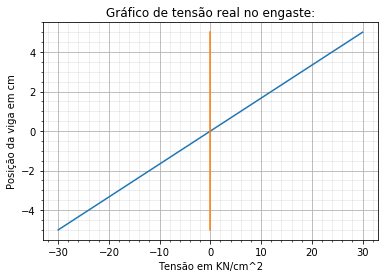

In [158]:
print("O gráfico da tensão real no engaste eh:")
x_i = [h0/2*P*(L-0)/I,-h0/2*P*(L-0)/I]
x_0 = [0,0]
y_i = [-h0/2,h0/2]
plt.xlabel('Tensão em KN/cm^2')
plt.ylabel("Posição da viga em cm")
plt.plot(x_i,y_i)
plt.plot(x_0,y_i)
plt.title('Gráfico de tensão real no engaste:')
plt.grid()
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()
plt.close()

O gráfico da tensão estimada no engaste é:


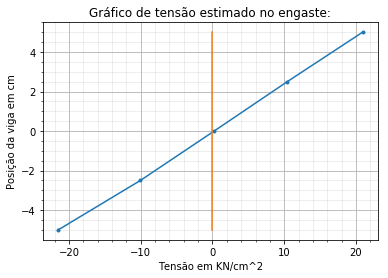

In [159]:
print("O gráfico da tensão estimada no engaste é:")
if n >1:
    x_e = [float(np.dot(np.dot(D,B[x%2]),Q[x].T)[0]+np.dot(np.dot(D,B[(x+1)%2]),Q[x+1].T)[0])/2 for x in range(0,2*n,2) ]
    y_e = [(x*h*(n)/(n-1)-h0/2) for x in range(n)]
    x_e0 = [0 for x in range(n)]
else:
    x_e = [float(np.dot(np.dot(D,B[x%2]),Q[x].T)[0]) for x in range(2*n) ]
    y_e = [(x*(h/2)*(2*n)/(2*n-1)-h0/2) for x in range(2*n)]
    x_e0 = [0 for x in range(2*n)]
plt.xlabel('Tensão em KN/cm^2')
plt.ylabel("Posição da viga em cm")
plt.plot(x_e,y_e,marker = '.')
plt.plot(x_e0,y_e)
plt.title('Gráfico de tensão estimado no engaste:')
plt.grid()
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()
plt.close()

O gráfico de tensão real a  100.0 cm de distância do engaste:


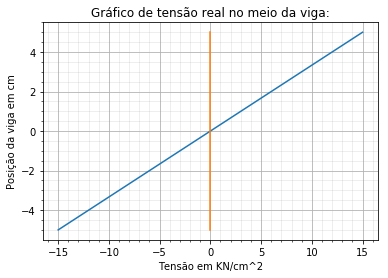

In [160]:
print("O gráfico de tensão real a ",math.ceil(L/h)/2*h,"cm de distância do engaste:")
x_i = [h0/2*P*(L-math.ceil(L/h)/2*h)/I,-h0/2*P*(L-math.ceil(L/h)/2*h)/I]
plt.xlabel('Tensão em KN/cm^2')
plt.ylabel("Posição da viga em cm")
plt.plot(x_i,y_i)
plt.plot(x_0,y_i)
plt.title('Gráfico de tensão real no meio da viga:')
plt.grid()
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()


O gráfico da tensão estimada no meio da viga é:


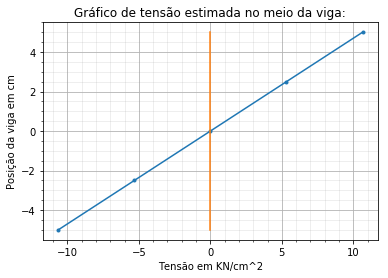

In [161]:
print("O gráfico da tensão estimada no meio da viga é:")
k_m = int((math.ceil(L/h))/2-1)
if n>1:
    x_e = [float(np.dot(np.dot(D,B[x%2]),Q[2*k_m*n+x].T)[0]+np.dot(np.dot(D,B[(x+1)%2]),Q[2*k_m*n+x+1].T)[0])/2 for x in range(0,2*n,2) ]
else:
    x_e = [float(np.dot(np.dot(D,B[x%2]),Q[2*k_m*n+x].T)[0]) for x in range(2*n) ]
plt.xlabel('Tensão em KN/cm^2')
plt.ylabel("Posição da viga em cm")
plt.plot(x_e,y_e,marker = '.')
plt.plot(x_e0,y_e)
plt.title('Gráfico de tensão estimada no meio da viga:')
plt.grid()
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()

O gráfico da tensão real no fim da viga eh:


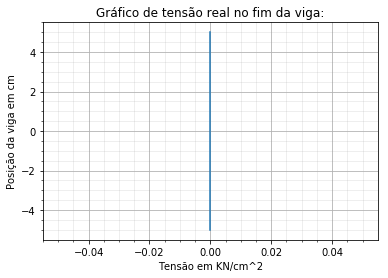

In [162]:
print("O gráfico da tensão real no fim da viga eh:")
x_i = [h0/2*P*(L-L)/I,-h0/2*P*(L-L)/I]
y_i = [-h0/2,h0/2]
plt.xlabel('Tensão em KN/cm^2')
plt.ylabel("Posição da viga em cm")
plt.plot(x_i,y_i)
plt.title('Gráfico de tensão real no fim da viga:')
plt.grid()
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()

O gráfico da tensão estimada no fim da viga é:


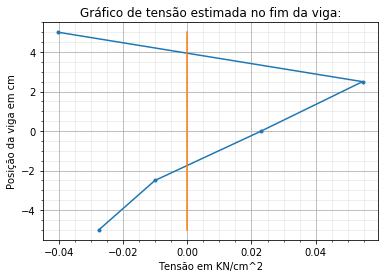

In [163]:
print("O gráfico da tensão estimada no fim da viga é:")
if n>1:
    x_e = [float(np.dot(np.dot(D,B[x%2]),Q[2*(M*n-1)*n+x].T)[0]+np.dot(np.dot(D,B[(x+1)%2]),Q[2*(M*n-1)*n+x+1].T)[0])/2 for x in range(0,2*n,2) ]
else:
    x_e = [float(np.dot(np.dot(D,B[x%2]),Q[2*(M*n-1)*n+x].T)[0]) for x in range(2*n) ]
plt.xlabel('Tensão em KN/cm^2')
plt.ylabel("Posição da viga em cm")
plt.plot(x_e,y_e,marker = '.')
plt.plot(x_e0,y_e)
plt.title('Gráfico de tensão estimada no fim da viga:')
plt.grid()
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()

In [164]:
from graphics import *

### Representação da malha.
Rode a celula para gerar o gráfico.

In [165]:
L_max = 1700 #Comprimento, em pixels, da viga.
h0_a = L_max/M #Altura da viga em pixels.
h_a = h0_a/n #Altura do elemento em pixels.
xw,yw = 1800,800 #Dimensões da janela gráfica. Diminua ou aumente de acordo com seu monitor.
x00 = 20 #Inicio da viga na direção x.
y00 = yw/2+h0_a/2 #Inicio da viga na direção y.
win = GraphWin("Representação da malha",xw,yw) #Criação da janela gráfica
for y in range(n):
    for x in range(M*n):
        elem1 = Polygon(Point(x00+x*h_a,y00-y*h_a),Point(x00+h_a+x*h_a,y00-h_a-y*h_a),Point(x00+h_a+x*h_a,y00-y*h_a))
        elem2 = Polygon(Point(x00+h_a+x*h_a,y00-h_a-y*h_a),Point(x00+x*h_a,y00-y*h_a),Point(x00+x*h_a,y00-h_a-y*h_a))
        elem1.draw(win)
        elem2.draw(win)
win.getMouse() #Feche a janela clicando em algum lugar da tela, não em seu 'x'.
win.close()

### Deformação da malha e representação do gradiente de tensões
Organização das tensões por cor:


In [166]:
if n>1:
    Total_T = [float(np.dot(np.dot(D,B[x%2]),Q[x].T)[0]+np.dot(np.dot(D,B[(x+1)%2]),Q[x+1].T)[0])/2 for x in range(0,2*M*n**2,2)] # Lista com todas as tensões.
    a0= min(Total_T)#menor tensão
    an= max(Total_T)#maior tensão
else:
    Total_T = [float(np.dot(np.dot(D,B[x%2]),Q[x].T)[0]) for x in range(2*M*n**2)]
    a0= min(Total_T) #menor tensão
    an= max(Total_T) #maior tensão
def Cor(ak): #função que define a cor do elemento
    global a0,an,Total_T
    return math.floor(255*(Total_T[ak]-a0)/(an-a0)) 


Representação da malha sobre o efeito da força externa:

In [167]:
e = 0
Multiplicador_de_deformacao = 5.886
Q_a = Q.copy()*L_max/L * Multiplicador_de_deformacao
win = GraphWin("Deformacao da malha",xw,yw)
txt = Text(Point(150,20),("Multiplicador de deformacao = "+str(Multiplicador_de_deformacao)))
ex_ver = Circle(Point(45,50),13)
ex_ver.setFill(color_rgb(255,0,0))
txt_ver = Text(Point(150,50),'Tensoes mais elevadas')
ex_azul = Circle(Point(45,80),13)
ex_azul.setFill(color_rgb(0,0,255))
txt_azul = Text(Point(155,80),'Tensoes menos elevadas')
ex_azul.draw(win)
ex_ver.draw(win)
txt_ver.draw(win)
txt_azul.draw(win)
txt.draw(win)

if n>1:
    for x in range(M*n):
        for y in range(n):
            elem1 = Polygon(Point(x00+x*h_a+Q_a[e][0][0],y00-y*h_a-Q_a[e][0][1]),Point(x00+h_a+x*h_a+Q_a[e][0][2],y00-h_a-y*h_a-Q_a[e][0][3]),Point(x00+h_a+x*h_a+Q_a[e][0][4],y00-y*h_a-Q_a[e][0][5]))
            e += 1
            elem2 = Polygon(Point(x00+h_a+x*h_a+Q_a[e][0][0],y00-h_a-y*h_a-Q_a[e][0][1]),Point(x00+x*h_a+Q_a[e][0][2],y00-y*h_a-Q_a[e][0][3]),Point(x00+x*h_a+Q_a[e][0][4],y00-h_a-y*h_a-Q_a[e][0][5]))
            e += 1
            elem1.setFill(color_rgb(Cor(int(e/2)-1),0,255-Cor(int(e/2)-1)))
            elem2.setFill(color_rgb(Cor(int(e/2)-1),0,255-Cor(int(e/2)-1)))
            elem1.draw(win)
            elem2.draw(win)
    win.getMouse() #Feche a janela clicando em algum lugar da tela, não em seu 'x'.
    win.close()
else:
    for x in range(M*n):
        for y in range(n):
            elem1 = Polygon(Point(x00+x*h_a+Q_a[e][0][0],y00-y*h_a-Q_a[e][0][1]),Point(x00+h_a+x*h_a+Q_a[e][0][2],y00-h_a-y*h_a-Q_a[e][0][3]),Point(x00+h_a+x*h_a+Q_a[e][0][4],y00-y*h_a-Q_a[e][0][5]))
            e += 1
            elem1.setFill(color_rgb(Cor(e-1),0,255-Cor(e-1)))
            elem2 = Polygon(Point(x00+h_a+x*h_a+Q_a[e][0][0],y00-h_a-y*h_a-Q_a[e][0][1]),Point(x00+x*h_a+Q_a[e][0][2],y00-y*h_a-Q_a[e][0][3]),Point(x00+x*h_a+Q_a[e][0][4],y00-h_a-y*h_a-Q_a[e][0][5]))
            e += 1
            elem2.setFill(color_rgb(Cor(e-1),0,255-Cor(e-1)))
            elem1.draw(win)
            elem2.draw(win)
    win.getMouse() #Feche a janela clicando em algum lugar da tela, não em seu 'x'.
    win.close()